In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error

In [22]:
def load_data(file_path):
    df = pd.read_csv(r'C:\baitapthuchanh\monthly_champagne_sales.csv')
    df['Month'] = pd.to_datetime(df['Month'])
    df.set_index('Month', inplace=True)
    return df

In [23]:
df = load_data('monthly_champagne_sales.csv')
print("\nThông tin bộ dữ liệu:")
df.info()


Thông tin bộ dữ liệu:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105 entries, 1964-01-01 to 1972-09-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   105 non-null    int64
dtypes: int64(1)
memory usage: 1.6 KB


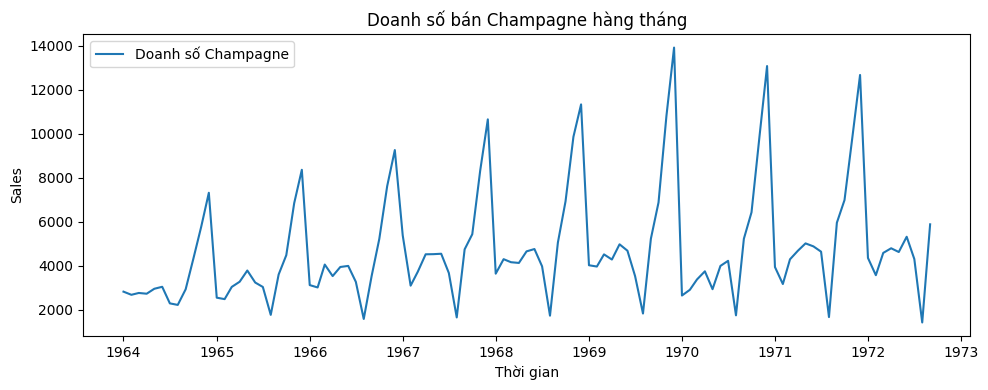

In [24]:
plt.figure(figsize=(10, 4))
plt.plot(df["Sales"], label="Doanh số Champagne")
plt.title("Doanh số bán Champagne hàng tháng")
plt.xlabel("Thời gian")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()

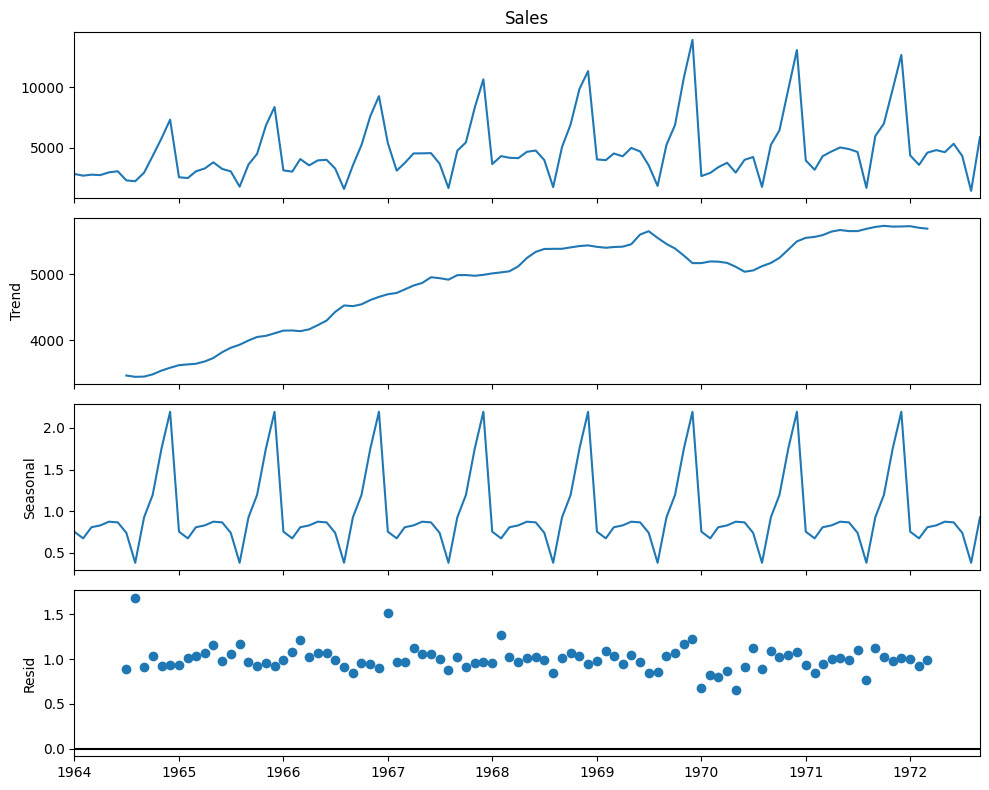

In [25]:
decomp = seasonal_decompose(df["Sales"], model="multiplicative", period=12)
fig = decomp.plot()
fig.set_size_inches(10, 8)
plt.tight_layout()
plt.show()

In [26]:
def analyze_seasonality(df):
    monthly_avg = df.groupby(df.index.month)['Sales'].mean()
    q4_avg = monthly_avg[10:13].mean()
    year_avg = monthly_avg.mean()
    q4_premium = (q4_avg - year_avg) / year_avg * 100
    
    print("Doanh số trung bình theo tháng:")
    for month, avg in monthly_avg.items():
        print(f"Tháng {month}: {avg:.0f}")
    print(f"\nQ4 cao hơn trung bình: {q4_premium:.1f}%")
    return monthly_avg

def find_best_sarima(train):
    best_aic = float('inf')
    best_params = ((1,1,1), (1,1,1,12))
    
    for p in [0,1,2]:
        for d in [0,1]:
            for q in [0,1,2]:
                for P in [0,1]:
                    for D in [0,1]:
                        for Q in [0,1]:
                            try:
                                model = SARIMAX(train, order=(p,d,q), seasonal_order=(P,D,Q,12))
                                fitted = model.fit(disp=False)
                                if fitted.aic < best_aic:
                                    best_aic = fitted.aic
                                    best_params = ((p,d,q), (P,D,Q,12))
                            except:
                                continue
    return best_params

def sarima_forecast(train, periods):
    order, seasonal_order = find_best_sarima(train)
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    fitted = model.fit(disp=False)
    forecast = fitted.forecast(steps=periods)
    return forecast, fitted.aic

def holtwinters_forecast(train, periods):
    model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12)
    fitted = model.fit()
    forecast = fitted.forecast(steps=periods)
    return forecast, fitted.aic


In [27]:
def compare_models(df):
    # Split data: 80% train, 20% test
    split_point = int(len(df) * 0.8)
    train = df['Sales'][:split_point]
    test = df['Sales'][split_point:]
    
    print(f"\nSo sánh mô hình (test trên {len(test)} tháng cuối):")
    
    # SARIMA
    sarima_pred, sarima_aic = sarima_forecast(train, len(test))
    sarima_mae = mean_absolute_error(test, sarima_pred)
    sarima_mape = np.mean(np.abs((test - sarima_pred) / test)) * 100
    
    # Holt-Winters
    hw_pred, hw_aic = holtwinters_forecast(train, len(test))
    hw_mae = mean_absolute_error(test, hw_pred)
    hw_mape = np.mean(np.abs((test - hw_pred) / test)) * 100
    
    print(f"SARIMA: MAE={sarima_mae:.0f}, MAPE={sarima_mape:.1f}%, AIC={sarima_aic:.1f}")
    print(f"Holt-Winters: MAE={hw_mae:.0f}, MAPE={hw_mape:.1f}%, AIC={hw_aic:.1f}")
    
    # Plot comparison
    plt.figure(figsize=(12, 6))
    plt.plot(test.index, test, 'o-', label='Thực tế', color='black', linewidth=2)
    plt.plot(test.index, sarima_pred, 's--', label=f'SARIMA (MAPE: {sarima_mape:.1f}%)', color='red')
    plt.plot(test.index, hw_pred, '^--', label=f'Holt-Winters (MAPE: {hw_mape:.1f}%)', color='blue')
    plt.title('So sánh dự báo vs thực tế')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return 'SARIMA' if sarima_mae < hw_mae else 'Holt-Winters'

In [28]:
def forecast_q4(df):
    train = df['Sales']
    
    # Dự báo 3 tháng (Q4)
    sarima_pred, _ = sarima_forecast(train, 3)
    
    # Tạo tháng dự báo
    last_date = df.index[-1]
    forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=3, freq='MS')
    
    print(f"\nDự báo Q4 {forecast_dates[0].year}:")
    total = 0
    for i, date in enumerate(forecast_dates):
        month_name = date.strftime('%b %Y')
        forecast_val = sarima_pred.iloc[i]
        print(f"{month_name}: {forecast_val:.0f}")
        total += forecast_val
    
    print(f"Tổng Q4: {total:.0f}")
    
    # Biểu đồ dự báo
    plt.figure(figsize=(12, 6))
    plt.plot(df.index[-24:], df['Sales'][-24:], 'o-', label='Lịch sử', color='blue')
    plt.plot(forecast_dates, sarima_pred, 's-', label='Dự báo Q4', color='red', markersize=8)
    plt.title('Dự báo doanh số Q4')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return sarima_pred

Phân tích dự báo doanh số sâm panh

So sánh mô hình (test trên 21 tháng cuối):
SARIMA: MAE=5071, MAPE=100.0%, AIC=10.0
Holt-Winters: MAE=659, MAPE=16.0%, AIC=1137.9


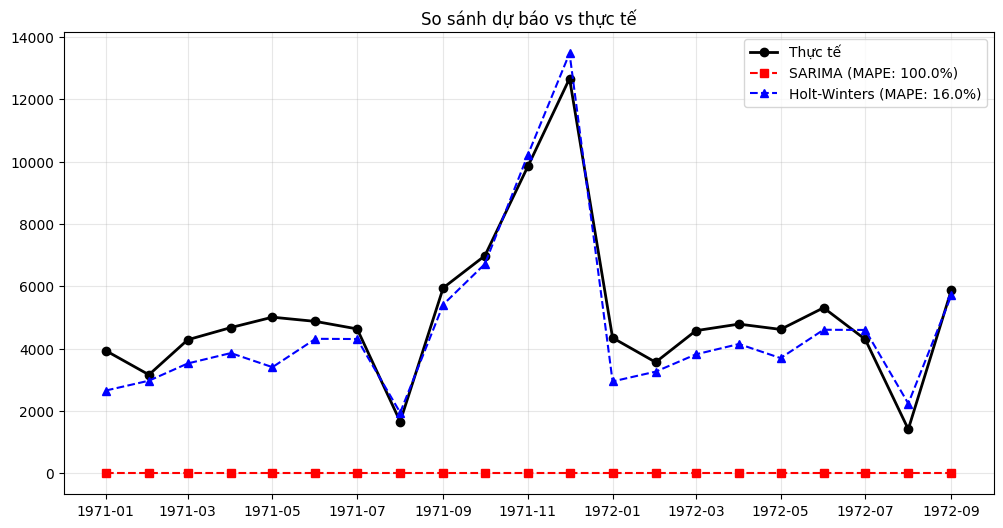


Mô hình tốt nhất: Holt-Winters

Dự báo Q4 1972:
Oct 1972: 7035
Nov 1972: 10054
Dec 1972: 12975
Tổng Q4: 30064


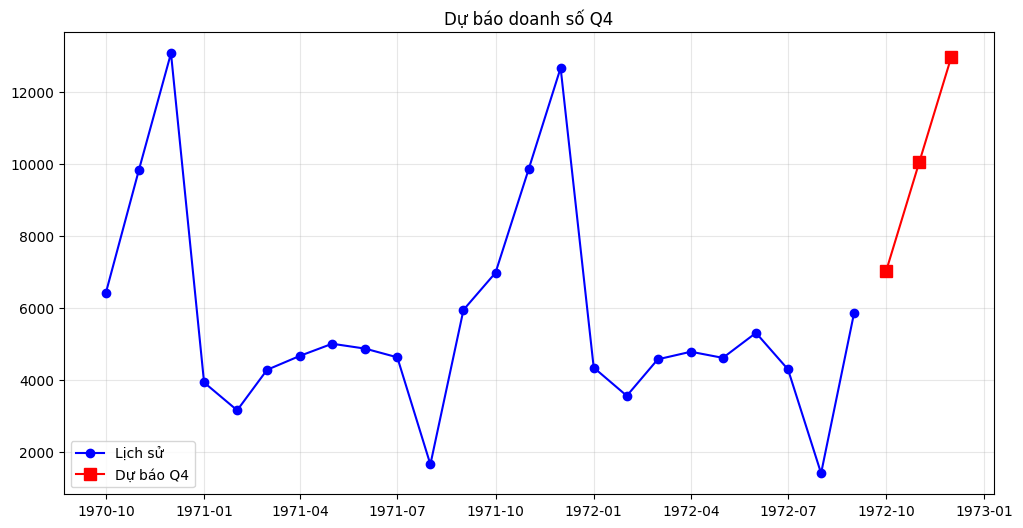

In [29]:
def main():
    print("Phân tích dự báo doanh số sâm panh")
    print("=" * 40)
    # So sánh mô hình
    best_model = compare_models(df)
    print(f"\nMô hình tốt nhất: {best_model}")
    
    # Dự báo Q4
    q4_forecast = forecast_q4(df)

if __name__ == "__main__":
    main()